In [ ]:
from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.endpoints import boxscoresummaryv2
import pandas
import sqlite3
from tqdm import tqdm_notebook
conn = sqlite3.connect("nba2.db")

In [ ]:
from nba_api.stats.endpoints import commonplayerinfo
c = conn.cursor()
c.execute("SELECT Player.id FROM Player WHERE height IS NULL")
players = c.fetchall()
for player in players:
    player_info = commonplayerinfo.CommonPlayerInfo(player_id=player[0])
    info = player_info.common_player_info.get_dict()["data"][0]
    print(info[0])
    c.execute("UPDATE Player SET height=?, weight=? WHERE id=?", (info[10], info[11], info[0]))
    conn.commit()

In [ ]:
s= [f"20{i}-{i+1}" for i in range(12, 9, -1)] + ["2009-10"] + [f"200{i}-0{i+1}" for i in range(8, 6, -1)]
c = conn.cursor()
for season in s:
    player_league_info = leaguegamelog.LeagueGameLog(player_or_team_abbreviation="P", season=season)
    player_info = player_league_info.get_data_frames()
    #team_info = team_league_info.get_data_frames()
    for index, row in tqdm_notebook(player_info[0].iterrows(), total=player_info[0].shape[0]):
        # Player if not exists
        pid, gid = row["PLAYER_ID"], row["GAME_ID"]
        tid = row["TEAM_ID"]
        c.execute("SELECT id FROM Player WHERE id = ?", (pid,))
        if c.fetchone() is None: # Create a new Player
            c.execute("INSERT INTO Player(id, name) VALUES (?, ?)", (pid, row["PLAYER_NAME"]))
        # Game if not exists
        c.execute("SELECT id FROM Game WHERE id = ?", (gid,))
        if c.fetchone() is None:
            c.execute("INSERT INTO Game(id, date) VALUES (?, ?)", (gid, row["GAME_DATE"]))
            # if we won, put our id in the winnerid
        if "@" in row["MATCHUP"]: # we played away
            c.execute("UPDATE Game SET awayid=? WHERE id=?",
                  (row["TEAM_ID"], gid))
        else: # we played home
            c.execute("UPDATE Game SET homeid=? WHERE id=?",
                  (row["TEAM_ID"], gid))
        if row["WL"] == "W":
            c.execute("UPDATE Game SET winnerid=? WHERE id=?", (row["TEAM_ID"], gid))
            
        # Team if not exists
        c.execute("SELECT id from Team WHERE id = ?", (tid,))
        if c.fetchone() is None:
            c.execute("INSERT INTO Team(id, name, abbr) VALUES (?, ?, ?)", (tid, row["TEAM_NAME"], row["TEAM_ABBREVIATION"]))
        # Fill in PlayerGame and TeamGame
        c.execute("SELECT id FROM PlayerGame WHERE gid=? AND pid=?", (gid, pid))
        if c.fetchone() is not None:
            c.execute("DELETE FROM PlayerGame WHERE gid=? AND pid=?", (gid, pid))
        c.execute("INSERT INTO PlayerGame(gid, pid, three_pct, ft_pct, fg_pct, teamid, playtime,\
                    pts, ft_made, three_pts, oreb, dreb, blk, ast, tov, pf) VALUES (?, ?, ?, ?, ?, ?, \
                    ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
                 (gid, pid, row["FG3_PCT"],  row["FT_PCT"], row["FG_PCT"], tid, row["MIN"],
                 row["PTS"], row["FTM"], row["FG3M"], row["OREB"], row["DREB"], row["BLK"], row["AST"],
                 row["TOV"], row["PF"]))
    conn.commit()
    print("Commited season "+season)

In [ ]:
import keras
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import numpy as np
from datetime import datetime, timedelta
import sqlite3
# validation data is the last 20% of the season
# break even percentage is 1/decimal odds

class DataGenerator(Sequence):
    def __init__(self, dbname, x_set, y_set, batch_size=32, dim=(5, 5),n_chan=7,
                shuffle=True, isValidation=False):
        self.batch_size=batch_size
        self.dim=dim
        self.n_chan=n_chan
        self.shuffle=shuffle
        self.isValidation = isValidation
        self.dbname=dbname
        self.x, self.y = x_set, y_set
        print(self.x[:10], self.y[:10])
    def __len__(self):
        return int(np.floor(len(self.x)/self.batch_size))
    def __getitem__(self, index):
        batch_x = self.x[index*self.batch_size:(index+1)*self.batch_size]
        batch_y = self.y[index*self.batch_size:(index+1)*self.batch_size]
        # batch_x contains a list of gameIDs... make "images" from these
        X = np.zeros((self.batch_size, self.n_chan, *self.dim))
        Y = np.asarray(batch_y)
        for i, sample in enumerate(batch_x):
            X[i,] = self.makeSample(sample)
        return X, Y
        
    def makeSample(self, gameid):
        # create a (5,5) with 6 channels (different stats)
        # select the top 5 players from each team based on playtime
        c=sqlite3.connect(self.dbname).cursor()
        c.execute("SELECT homeid, awayid, date FROM Game WHERE id=?", (gameid,))
        homeid, awayid, date = c.fetchone()
        print(date)
        c.execute("SELECT Team.id, Player.id, Player.name\
                        FROM PlayerGame as pg, Game, Player, Team\
                        WHERE Game.id=? AND pg.gid=Game.id\
                        AND pg.pid=Player.id AND pg.teamid=Team.id\
                        ORDER BY pg.teamid, pg.playtime DESC", (gameid,))
        # for each of these players, calulate their averages from last 8 games
        #print("pg.three_pct, pg.pts, pg.fg_pct, pg.ft_pct, pg.ast, pg.tov, pg.blk")
        home, away = [], []
        for team, player, name in c.fetchall():
            #print(name)
            #since = datetime.strptime(date, "%Y-%m-%d") - timedelta(days=60)
            #d = since.strftime("%Y-%m-%d")
            c.execute("SELECT AVG(coalesce(f.three_pct,0)), AVG(f.pts), AVG(coalesce(f.fg_pct,0)),\
                            AVG(coalesce(f.ft_pct,0)), AVG(f.ast), AVG(f.tov), AVG(f.blk)\
                            FROM (SELECT pg.three_pct, pg.pts, pg.fg_pct, pg.ft_pct, pg.ast, pg.tov, pg.blk\
                                FROM PlayerGame as pg, Game as g1 WHERE\
                            pg.pid=? AND pg.gid=g1.id\
                            AND g1.date < ? AND g1.date > ?) as f", (player,date, date-2592000))
            if str(team) == homeid:
                home.append(c.fetchone())
            else:
                away.append(c.fetchone())
        #print(home, away)
        num_features = len(home[0])
        features = np.zeros((self.n_chan, *self.dim))
        for z in range(self.n_chan):
            for x in range(self.dim[0]): # iterating over the home players
                for y in range(self.dim[0]): # over the away players
                    features[z, x, y] = home[x][z] - away[y][z]
            # normalize the feature between -1 and 1
            f = features[z]
            features[z] = 2*(f-f.min())/(f.max()-f.min()) -1
        return features
        # order the players by height
        # pg.three_pct, pg.pts, pg.fg_pct, pg.ft_pct, pg.ast, pg.tov
        # do home-away for each of the stats. (then -1 to 1 normalization)
        # return the 5x5x6

In [ ]:
from sklearn.model_selection import train_test_split
import random
import sqlite3
from keras import backend
import glob, os
samples = []
labels = []
with sqlite3.connect("nba2.db") as conn:
    c = conn.cursor()
    for season in [f"20{str(i).zfill(2)}" for i in range(7, 20)]:
        for file in glob.glob(f"samples/{season}/*.npy"):
            samples.append(np.load(file))
            gid = os.path.basename(file).rstrip(".npy")
            c.execute("Select CASE WHEN Game.winnerid=Game.homeid THEN 1\
                            ELSE 0 END AS label FROM Game WHERE Game.id=?", (gid,))
            labels.append(c.fetchone())
# Naive random oversample
diff = len(labels)//2 - labels.count((0,))
for i in range(diff):
    while True:
            a = random.randint(1, len(labels)-1)
            if labels[a] == (0,):
                samples.append(samples[a])
                labels.append((0,))
                break
samples = np.stack(samples)
labels = np.stack(labels)
print(samples.shape, labels.shape)
t_split = int(samples.shape[0]*0.8)
x_train, x_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, random_state=30)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.optimizers import RMSprop
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(2, 2), input_shape=(7, 5, 5),
                 data_format="channels_first", activation="relu"))
#model.add(Conv2D(filters=32, kernel_size=(1, 1), activation="relu"))
#model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu",))
#model.add(Conv2D(filters=32, kernel_size=(3, 3),activation="relu"))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
print(model.summary())
adm = Adam(lr=0.0001)
model.compile(loss="binary_crossentropy", optimizer=adm,metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=16,validation_data=(x_test, y_test), verbose=1,epochs=5)

In [ ]:
predictions = model.predict(samples[:10])
predictions

# Version 2

## Add columns

In [ ]:
from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.endpoints import boxscoresummaryv2
from nba_api.stats.endpoints import boxscoreadvancedv2
from nba_api.stats.endpoints import boxscoretraditionalv2
import pandas
import sqlite3
from tqdm import tqdm_notebook
conn = sqlite3.connect("nba2.db")
c = conn.cursor()

player_info = boxscoreadvancedv2.BoxScoreAdvancedV2("0020700001")
for col in player_info.player_stats.get_data_frame().columns[8:]:
    try:
        print(col)
        c.execute(f"ALTER TABLE PlayerGameADV ADD {col} REAL")
    except:
        pass
player_info = boxscoretraditionalv2.BoxScoreTraditionalV2("0020700001")
for col in player_info.player_stats.get_data_frame().columns[9:]:
    try:
        print(col)
        c.execute(f"ALTER TABLE PlayerGameTRAD ADD {col} REAL")
    except:
        pass
conn.commit()

In [ ]:
from nba_api.stats.endpoints import boxscoreadvancedv2
from nba_api.stats.endpoints import boxscoretraditionalv2
import sqlite3
import code
from tqdm import tqdm_notebook
from multiprocessing import Pool
conn = sqlite3.connect("nba2.db")
c = conn.cursor()
c.execute("SELECT id FROM Game")
gameids = c.fetchall()
#columns = c.execute("PRAGMA table_info(PlayerGame)").fetchall()

with Pool(20) as p:
    p.map(code.insert_into_db, [g[0] for g in gameids])

    
    #players_info.rename({'GAME_ID': 'gid', 'TEAM_ID': 'teamid', 'PLAYER_ID':'pid'}, axis='columns', inplace=True)
    #stats = players_info.loc[:, "MIN":] 
    #print(stats)
    #stats.to_sql("PlayerGame", conn, if_exists="append", index=False)
        

In [ ]:
import sqlite3
from pymongo import MongoClient
client = MongoClient()
db = client.nba
collection = db.games
conn = sqlite3.connect("nba2.db")
c = conn.cursor()
c.execute("SELECT * FROM Game")
gameids = c.fetchall()
normalized_d = [{"GAME_ID":"00"+str(g[0]), "DATE":g[1], "HOME":g[2], "AWAY":g[3], "WINNER":g[4]} for g in gameids]
collection.insert_many(normalized_d)

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
from pymongo import MongoClient
import pandas as pd
import re, os
import numpy as np
from tqdm import tqdm
import pickle
with open("adv.txt") as f, open("trad.txt") as g:
    adv_stats = [x.strip() for x in f.readlines()]
    trad_stats = [x.strip() for x in g.readlines()]
client = MongoClient()
db = client.nba
boxtrad = db.trad
boxadv = db.adv
games = db.games
seasons = [f"002{str(i).zfill(2)}" for i in range(7, 20)]
for season in seasons:
    if not os.path.isdir(f"samples/{season}"):
        os.mkdir(f"samples/{season}")
    players_adv, players_trad = {}, {}
    rgx = re.compile(f"^{season}.*")
    seasons_games = games.find({"GAME_ID":rgx})
    players_games = boxtrad.find({"GAME_ID":rgx})
    for pg in tqdm(players_games):
        if pg["PLAYER_ID"] not in players_adv: 
             # if we don't have the player, get all games player has played in this season
            player_adv = boxadv.aggregate([
                        {"$match":{"GAME_ID":rgx, "PLAYER_ID":pg["PLAYER_ID"]}},
                        {"$lookup":{
                            "from": "games",
                            "localField": "GAME_ID",
                            "foreignField": "GAME_ID",
                            "as": "GAME_INFO"}
                        },
                        {"$unwind":"$GAME_INFO"}])
            player_trad = boxtrad.aggregate([
                        {"$match":{"GAME_ID":rgx, "PLAYER_ID":pg["PLAYER_ID"]}},
                        {"$lookup":{
                            "from": "games",
                            "localField": "GAME_ID",
                            "foreignField": "GAME_ID",
                            "as": "GAME_INFO"}
                        },
                        {"$unwind":"$GAME_INFO"}
            ])
            players_adv[pg["PLAYER_ID"]] = pd.DataFrame(list(player_adv))
            players_trad[pg["PLAYER_ID"]] = pd.DataFrame(list(player_trad))
            players_adv[pg["PLAYER_ID"]]["MIN"] = players_adv[pg["PLAYER_ID"]]["MIN"].apply(lambda x: int(x.split(":")[0])*60+int(x.split(":")[1]) if x else 0)
            players_trad[pg["PLAYER_ID"]]["MIN"] = players_trad[pg["PLAYER_ID"]]["MIN"].apply(lambda x: int(x.split(":")[0])*60+int(x.split(":")[1]) if x else 0)
    pickle.dump( players_adv, open( f"samples/{season}_adv.p", "wb" ) )
    pickle.dump( players_trad, open( f"samples/{season}_trad.p", "wb" ) )

    for game in tqdm(seasons_games):
        home, away = [], []
        player_ids = boxadv.find({"GAME_ID":game["GAME_ID"]}, {"PLAYER_ID":1, "TEAM_ID":1})
        for pid in player_ids:
            new = players_adv[pid["PLAYER_ID"]].loc[players_adv[pid["PLAYER_ID"]]["GAME_INFO"].str["DATE"] < game["DATE"], adv_stats].mean()
            new2 = players_trad[pid["PLAYER_ID"]].loc[players_trad[pid["PLAYER_ID"]]["GAME_INFO"].str["DATE"] < game["DATE"], trad_stats].mean()
            if game["HOME"] == str(pid["TEAM_ID"]):
                home.append(np.nan_to_num(np.concatenate((new.to_numpy(), new2.to_numpy()))))
            else:
                away.append(np.nan_to_num(np.concatenate((new.to_numpy(), new2.to_numpy()))))
        home.sort(key=lambda x: x[0], reverse=True) # sort by time played (seconds)
        away.sort(key=lambda x: x[0], reverse=True)
        sample = np.stack([np.vstack(home[:8]), np.vstack(away[:8])])
        np.save(f"samples/{season}/{game['GAME_ID']}.npy", sample)

In [ ]:
from pymongo import MongoClient
import pandas as pd
import re
client = MongoClient()
db = client.nba
boxtrad = db.trad
boxadv = db.adv
games = db.games
players_adv, players_trad = {}, {}
rgx = re.compile(f"^00207.*")
players_games = boxtrad.find({"GAME_ID":rgx})
for pg in tqdm(players_games):
        if pg["PLAYER_ID"] not in players_adv: 
             # if we don't have the player, get all games player has played in this season
            player_adv = boxadv.aggregate([
                        {"$match":{"GAME_ID":rgx, "PLAYER_ID":pg["PLAYER_ID"]}},
                        {"$lookup":{
                            "from": "games",
                            "localField": "GAME_ID",
                            "foreignField": "GAME_ID",
                            "as": "GAME_INFO"}
                        },
                        {"$unwind":"$GAME_INFO"}])
            player_trad = boxtrad.aggregate([
                        {"$match":{"GAME_ID":rgx, "PLAYER_ID":pg["PLAYER_ID"]}},
                        {"$lookup":{
                            "from": "games",
                            "localField": "GAME_ID",
                            "foreignField": "GAME_ID",
                            "as": "GAME_INFO"}
                        },
                        {"$unwind":"$GAME_INFO"}
            ])
            players_adv[pg["PLAYER_ID"]] = pd.DataFrame(list(player_adv))
            players_trad[pg["PLAYER_ID"]] = pd.DataFrame(list(player_trad))
            players_adv[pg["PLAYER_ID"]]["MIN"] = players_adv[pg["PLAYER_ID"]]["MIN"].apply(lambda x: int(x.split(":")[0])*60+int(x.split(":")[1]) if x else 0)
            players_trad[pg["PLAYER_ID"]]["MIN"] = players_trad[pg["PLAYER_ID"]]["MIN"].apply(lambda x: int(x.split(":")[0])*60+int(x.split(":")[1]) if x else 0)

In [ ]:
import numpy as np
with open("adv.txt") as f, open("trad.txt") as g:
    adv_stats = [x.strip() for x in f.readlines()]
    trad_stats = [x.strip() for x in g.readlines()]
seasons_games = games.find({"GAME_ID":"0020700380"})
for game in tqdm(seasons_games):
        home, away = [], []
        player_ids = boxadv.find({"GAME_ID":game["GAME_ID"]}, {"PLAYER_ID":1, "TEAM_ID":1})
        for pid in player_ids:
            new = players_adv[pid["PLAYER_ID"]].loc[players_adv[pid["PLAYER_ID"]]["GAME_INFO"].str["DATE"] < game["DATE"], adv_stats].mean()
            new2 = players_trad[pid["PLAYER_ID"]].loc[players_trad[pid["PLAYER_ID"]]["GAME_INFO"].str["DATE"] < game["DATE"], trad_stats].mean()
            if game["HOME"] == str(pid["TEAM_ID"]):
                home.append(np.nan_to_num(np.concatenate([new.to_numpy(), new2.to_numpy()])))
            else:
                away.append(np.nan_to_num(np.concatenate([new.to_numpy(), new2.to_numpy()])))
        home.sort(key=lambda x: x[0], reverse=True) # sort by time played (seconds)
        away.sort(key=lambda x: x[0], reverse=True)
        sample = np.stack([np.vstack(home[:8]), np.vstack(away[:8])])
        np.save(f"samples/{season}/{game['GAME_ID']}.npy", sample)

In [1]:
import os
import numpy as np
from tqdm import tqdm
from pymongo import MongoClient
bookies = {
    "44":"Betfair",
    "16":"bet365",
    "18":"Pinnacle",
    "5":"Unibet"
}
client = MongoClient()
db = client.nba
games = db.games

seasons = [f"002{str(i).zfill(2)}" for i in range(8, 20)]
# load the samples into memory
x, y = [], []
def normalize_sample(nparr):
    for feature in range(nparr.shape[-1]): # iterate over the features
        f = np.nan_to_num(nparr[:, :, feature])
        nparr[:, :, feature] = (f-f.min())/(f.max()-f.min())
    return nparr

for season in seasons:
    for filename in tqdm(os.listdir(f"samples/{season}")[120:]):
        if ".npy" in filename:
            game = list(games.find({"GAME_ID":filename.strip(".npy"), "bet365":{"$exists":"True"}}))
            if not game:
                continue
            game = game[0]
            closing_odds = 1/float(game["bet365"].split()[1].split("v")[0])
            home_win = int(game["HOME"] == game["WINNER"])
            sample = np.load(f"samples/{season}/{filename}")
            x.append((normalize_sample(sample), closing_odds))
            y.append(home_win)
x = np.array(x)
y = np.array(y)

import random
print(x.shape, y.shape)
diff = len(y)//2 - np.count_nonzero(y == 0)
for i in tqdm(range(diff)):
    while True:
            a = random.randint(1, len(y)-1)
            if y[a] == 1:
                x = np.delete(x, a, 0)
                y = np.delete(y, a, 0)
                break
print(len(x), len(y))


100%|██████████████████████████████████████████████████████████████████████████████| 1110/1110 [00:11<00:00, 98.96it/s]
0it [00:00, ?it/s]


In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.3, shuffle=False)

In [ ]:
x_train[0]

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.optimizers import RMSprop
model = Sequential()
shape = x[0].shape
print(shape)
model.add(Conv2D(filters=32, kernel_size=(8, 1), input_shape=shape,
                 data_format="channels_first", activation="relu"))
#model.add(Conv2D(filters=32, kernel_size=(1, 1), activation="relu"))
#model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu",))
#model.add(Conv2D(filters=32, kernel_size=(3, 3),activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
print(model.summary())
opt = Adam(lr=0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
#model.fit(x_train, y_train, batch_size=16,validation_data=(x_test, y_test), verbose=1,epochs=1)

In [15]:
history = model.fit(x_train, y_train, batch_size=16,validation_data=(x_test, y_test), verbose=1,epochs=5)

Train on 9139 samples, validate on 2285 samples
Epoch 1/5
9139/9139 [==============================] - 3s 290us/step - loss: 0.6766 - accuracy: 0.5663 - val_loss: 0.6470 - val_accuracy: 0.6499
Epoch 2/5
9139/9139 [==============================] - 2s 258us/step - loss: 0.6407 - accuracy: 0.6388 - val_loss: 0.6168 - val_accuracy: 0.6600
Epoch 3/5
9139/9139 [==============================] - 2s 257us/step - loss: 0.6293 - accuracy: 0.6539 - val_loss: 0.6104 - val_accuracy: 0.6661
Epoch 4/5
9139/9139 [==============================] - 2s 254us/step - loss: 0.6246 - accuracy: 0.6565 - val_loss: 0.6140 - val_accuracy: 0.6608
Epoch 5/5
9139/9139 [==============================] - 2s 251us/step - loss: 0.6258 - accuracy: 0.6595 - val_loss: 0.6099 - val_accuracy: 0.6674


In [40]:
model.predict(x[:10])

array([[0.87127066],
       [0.3972962 ],
       [0.71974295],
       [0.3513928 ],
       [0.68362457],
       [0.5905371 ],
       [0.5476573 ],
       [0.45593584],
       [0.5709136 ],
       [0.65808046]], dtype=float32)

In [29]:
history

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# collect headshots

In [ ]:
from pymongo import MongoClient
import requests_random_user_agent
from tqdm import tqdm
import os
import requests
client = MongoClient()
db = client.nba
boxtrad = db.trad
collect = boxtrad.find({})
seen = [x.strip(".png") for x in os.listdir("headshots")]
print(seen)
for pg in collect:
    pid = pg["PLAYER_ID"]
    if str(pid) in seen:
        continue
    header = {"Referrer":f"https://stats.nba.com/player/{pid}/"}
    headshot = requests.get(f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/latest/260x190/{pid}.png",
                            headers=header)
    if headshot.status_code != 200:
        seen.append(str(pid))
        continue
    with open(f"headshots/{pid}.png", "wb") as f:
        f.write(headshot.content)
        seen.append(str(pid))
    print(pid)


In [ ]:
import requests
a = requests.get("https://stats.nba.com/player/203991/")
print(a.content)

# Scrape bet history

In [5]:
import requests
from multiprocessing import Pool
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime
with open("team_names.txt") as f:
    teams = {x[1].strip():x[0] for x in (y.split("-") for y in f.readlines())}
with open("links.txt") as f:
    urls = [x.strip() for x in f.readlines()]
from pymongo import MongoClient
client = MongoClient()
db = client.nba
games = db.games
headers = {
    'cookie': 'js_cookie=1; my_cookie_id=101112686; my_cookie_hash=94b719f17654f45fad8f47626803f40a; upcoming=3-200; my_timezone=^%^2B1; widget_timeStamp=1576892147; page_cached=1; widget_pageViewCount=12',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)',
    'accept': 'application/json, text/javascript, */*; q=0.01',
    'referer': 'https://www.betexplorer.com',
    'authority': 'www.betexplorer.com',
    'x-requested-with': 'XMLHttpRequest',
}
bookies = {
    "44":"Betfair",
    "16":"bet365",
    "18":"Pinnacle",
    "5":"Unibet"
}

for url in urls:
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")
    table = soup.find("table", attrs={"class":"table-main h-mb15 js-tablebanner-t js-tablebanner-ntb"})
    rows = table.find_all("tr")
    for row in tqdm(rows):
        cols = row.find_all("td")
        versus = cols[0].a.find_all("span")
        home, away = versus[0].text, versus[1].text
        date = cols[4].text.split(".")
        if not date[2]:
            date[2] = datetime.now().year
        dt = datetime(int(date[2]), int(date[1]), int(date[0])).timestamp()
        if not cols[0].a.has_attr("href"):
            continue
        link = cols[0].a.attrs["href"]
        game_id = link.split("/")[-2]
        game_page = requests.get(f"https://www.betexplorer.com/match-odds/{game_id}/1/ha/", headers=headers)
        soup = BeautifulSoup(game_page.json()["odds"], "html.parser")
        table = soup.find("table", attrs={"class":"table-main h-mb15 sortable"})
        if not table:
            continue
        bookmakers = table.find_all("tr")[1:-1]
        if not bookmakers: # there were no bookmakers for this game
            continue
        for b in bookmakers:
            if not b.has_attr("data-bid"):
                continue
            bid = b.attrs["data-bid"]
            if bid not in bookies: # betfair, bet365, pinnacle, unibet
                continue
            cols = b.find_all("td")
            if not cols[3].has_attr("data-opening-odd"):
                cols[3].attrs["data-opening-odd"] = "1.0"
            if not cols[4].has_attr("data-odd"):
                cols[4].attrs["data-odd"] = "1.0"
            home_open, home_close = cols[3].attrs["data-opening-odd"], cols[3].attrs["data-odd"]
            away_open, away_close = cols[4].attrs["data-opening-odd"], cols[4].attrs["data-odd"]
            games.update_one({"HOME":str(teams[home]), "AWAY":str(teams[away]), "DATE":{"$gte":dt-86400, "$lte":dt+86400}},
                            {"$set":{bookies[bid]:f"{home_open}v{away_open} {home_close}v{away_close}"}})
        #print(home, teams[home], away, teams[away], date, bookies[bid], home_close, away_close)

100%|██████████████████████████████████████████████████████████████████████████████| 1230/1230 [32:01<00:00,  1.56s/it]


![loss](loss.png)

In [24]:
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Conv2D, Flatten, Activation, concatenate
from keras.optimizers import Adam

c = 0.6
def decorrelation_loss(neuron):
    def loss(y_actual, y_predicted):
        return K.mean(
                K.square(y_actual-y_predicted) - c * K.square(y_predicted - neuron))
    return loss

# split the two input streams
box_scores_train, odds_train = map(list, zip(*x_train))
box_scores_test, odds_test = map(list, zip(*x_test))

# box model turns stats into a vector
box_model = Sequential()
shape = box_scores_train[0].shape
print(shape)
box_model.add(Conv2D(filters=32, kernel_size=(1, 8), input_shape=shape,
                 data_format="channels_first", activation="relu"))
box_model.add(Flatten())

box_input = Input(shape=shape)
box_encoded = box_model(box_input)

odds_input = Input(shape=(1,), dtype="float32") #(opening or closing weight)
merged = concatenate([odds_input, box_encoded])
output = Dense(32, activation="relu")(merged)
output = Dropout(0.5)(output)
output = Dense(8, activation="relu")(output)
output = Dropout(0.5)(output)
signal = Dense(1, activation="sigmoid")(output)

opt = Adam(lr=0.0001)
nba_model = Model(inputs=[box_input, odds_input], outputs=signal)
print(nba_model.summary())

nba_model.compile(optimizer=opt,
                  #loss="binary_crossentropy",
              loss=decorrelation_loss(odds_input), # Call the loss function with the selected layer
              metrics=['accuracy'])
nba_model.fit([box_scores_train, odds_train], y_train,
              batch_size=16,validation_data=([box_scores_test, odds_test], y_test), verbose=1,epochs=20)

(2, 8, 42)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 2, 8, 42)     0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 8960)         544         input_7[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 8961)         0           input_8[0][0]                    
                                                                 sequential_4[1][

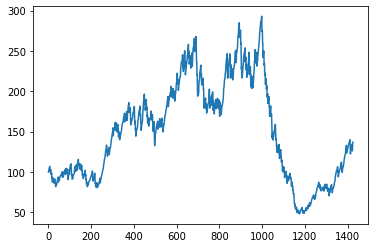

In [30]:
b, ods = map(list, zip(*x))
results = list(y)
balance = 100
history = [100]
predictions = nba_model.predict([b, ods])
for i, p in enumerate(predictions):
    if p[0] > 0.6:
        bet = balance * 0.1 * p[0]
        balance -= bet
        if results[i] == 1:
            balance += bet*(1/ods[i])
        history.append(balance)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history)

In [33]:
max(history)

292.9991237312299